In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymc import Model, Normal, sample, HalfNormal
import arviz as az

import yfinance as yf
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation
import warnings

import riskfolio as rp
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
start = '2014-12-31'
end = '2022-12-31'
ext_factors = pd.read_parquet('factors.parquet')
stock_prices = pd.read_parquet('stock_prices.parquet')
stock_rets = stock_prices.pct_change()
stock_return_daily = stock_rets.copy()
stock_rets = stock_rets.loc[start:end, :]
ext_factors = ext_factors.resample('M').agg(lambda x: (x + 1).prod() - 1)
stock_rets = stock_rets.resample('M').agg(lambda x: (x + 1).prod() - 1)

ext_factors[[f'{factor}_lag' for factor in ext_factors.columns]] = ext_factors.shift(1)
stock_rets[[f'{symbol}_lag' for symbol in stock_rets.columns]] = stock_rets.shift(1)

ext_factors = ext_factors.dropna()
stock_rets = stock_rets.dropna()


C:\Users\TGAdmin\AppData\Local\Temp\ipykernel_19644\1610211889.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_rets = stock_prices.pct_change()
C:\Users\TGAdmin\AppData\Local\Temp\ipykernel_19644\1610211889.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ext_factors = ext_factors.resample('M').agg(lambda x: (x + 1).prod() - 1)
C:\Users\TGAdmin\AppData\Local\Temp\ipykernel_19644\1610211889.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_rets = stock_rets.resample('M').agg(lambda x: (x + 1).prod() - 1)


In [3]:
# train/test split
start_train_at = '2014-12-31'
end_train_at = '2021-12-31'
start_test_at = '2022-01-31'
X_train = pd.concat([stock_rets.loc[start_train_at:end_train_at, :], ext_factors.loc[start_train_at:end_train_at, :]], axis=1)
X_test = pd.concat([stock_rets.loc[start_test_at:, :], ext_factors.loc[start_test_at:, :]], axis=1)

In [10]:
model_dict = {}
# universe = ['MINT.BK', 'BANPU.BK', 'TOP.BK', 
#            'DELTA.BK', 'IRPC.BK', 'PTTGC.BK', 
#            'WHA.BK', 'SCC.BK','CPN.BK', 
#            'CENTEL.BK', 'PTT.BK', 'BCP.BK']
universe = ['MINT.BK', 'BANPU.BK']
# symbols = ['SET_index']
def train(universe, with_esg=True):
    for symbol in universe:
        with Model() as model:
            if with_esg:
                beta0 = Normal('beta0', 0, 10)
                beta1 = Normal('beta1', 0, 10)
                beta2 = Normal('beta2', 0, 10)
                beta3 = Normal('beta3', 0, 10)
                beta4 = Normal('beta4', 0, 10)
                stdev = HalfNormal('stdev', 10)
                X_l1 = pm.MutableData( 'lagged_X', X_train.loc[:, f'{symbol}_lag'].values)
                R_l1 = pm.MutableData('lagged_R_l1', X_train.loc[:, 'mkt_lag'].values)
                R_l2 = pm.MutableData('lagged_R_l2',X_train.loc[:, 'E_lag'].values)
                R_l3 = pm.MutableData('lagged_R_l3',X_train.loc[:, 'S_lag'].values)
                R_l4 = pm.MutableData('lagged_R_l4',X_train.loc[:, 'G_lag'].values)
                X = X_train.loc[:, symbol].values
                mu = X_l1 * beta0 + R_l1 * beta1 + R_l2 * beta2 + R_l3 * beta3 + R_l4 * beta4
                obs = Normal('obs', mu=mu, sigma=stdev, observed=X)
                ar_trace = sample(20000, chains=1)
                model_dict[symbol] = ar_trace
            else:
                beta0 = Normal('beta0', 0, 10)
                beta1 = Normal('beta1', 0, 10)
                stdev = HalfNormal('stdev', 10)
                X_l1 = pm.MutableData( 'lagged_X', X_train.loc[:, f'{symbol}_lag'].values)
                R_l1 = pm.MutableData('lagged_R_l1', X_train.loc[:, 'mkt_lag'].values)
                X = X_train.loc[:, symbol].values
                mu = X_l1 * beta0 + R_l1 * beta1
                obs = Normal('obs', mu=mu, sigma=stdev, observed=X)
                ar_trace = sample(20000, chains=1)
                model_dict[symbol] = ar_trace
    return model_dict


In [11]:
import numpy as np
def predict(X, symbol, model, with_esg=True):
    draw = model.posterior['draw'].shape[0]
    
    beta0_sample = model.posterior['beta0']
    beta1_sample = model.posterior['beta1']
    if with_esg:
        beta2_sample = model.posterior['beta2']
        beta3_sample = model.posterior['beta3']
        beta4_sample = model.posterior['beta4']
        next_period_return = (X[f'{symbol}_lag'] * beta0_sample +
                              X['mkt_lag'] * beta1_sample + 
                              X['E_lag'] * beta2_sample + 
                              X['S_lag'] * beta3_sample + 
                              X['G_lag'] * beta4_sample)
    else:
        next_period_return = (X[f'{symbol}_lag'] * beta0_sample +
                              X['mkt_lag'] * beta1_sample)

    next_period_return = np.array(next_period_return).reshape(draw, )
    return next_period_return 

In [12]:
model_dict = train(universe, with_esg=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 29 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, beta2, beta3, beta4, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 27 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


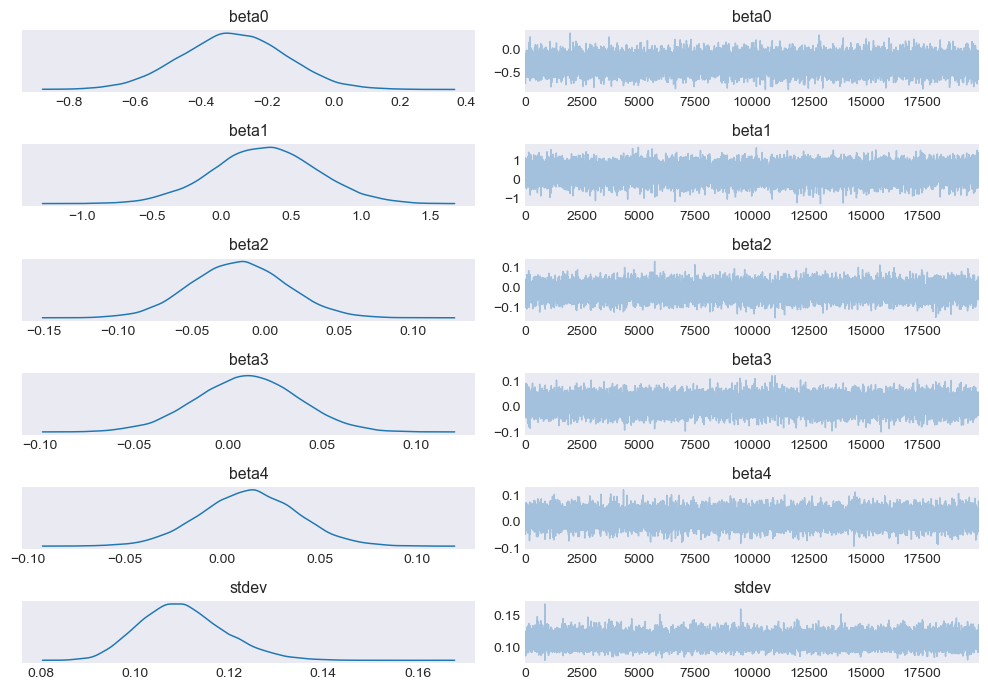

In [13]:
az.plot_trace(model_dict['MINT.BK'], figsize=(10, 7))
plt.tight_layout()

In [16]:
weights_dict = {}
perf_dict = {}
for idx in X_test.index:
    print(idx)
    portfolio = stock_prices.loc['2022-01-01':idx, universe]
    market_prices = stock_prices.loc['2015-01-01':idx, 'SET_index']
    mcaps = {}
    for t in universe:
        stock = yf.Ticker(t)
        mcaps[t] = stock.info["marketCap"]
    S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

    views = {}
    view_uncertainty = {}
    for symbol in universe:
        pred = predict(X_test.loc[idx, :], symbol, model_dict[symbol], with_esg=False)
        views[symbol] = pred.mean()
        view_uncertainty[symbol] = pred.var()

    omega = np.diag(list(view_uncertainty.values()))

    bl = BlackLittermanModel(S, pi="equal",
                             absolute_views=views, omega=omega)

    ret_bl = bl.bl_returns()
    S_bl = bl.bl_cov()

    ef = EfficientFrontier(ret_bl, S_bl)
    ef.add_objective(objective_functions.L2_reg)
    ef.max_sharpe(risk_free_rate=0.0227/12)
    weights = ef.clean_weights()
    weights_dict[idx] = weights
    perf_dict[idx] = ef.portfolio_performance(risk_free_rate=0, verbose=True)


2022-01-31 00:00:00
Expected annual return: 6.0%
Annual volatility: 15.5%
Sharpe Ratio: 0.37
2022-02-28 00:00:00
Expected annual return: 1.6%
Annual volatility: 23.9%
Sharpe Ratio: 0.06
2022-03-31 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The defaul

Expected annual return: 1.3%
Annual volatility: 21.2%
Sharpe Ratio: 0.05
2022-04-30 00:00:00
Expected annual return: 0.5%
Annual volatility: 30.9%
Sharpe Ratio: 0.01
2022-05-31 00:00:00
Expected annual return: 5.6%
Annual volatility: 31.9%
Sharpe Ratio: 0.17
2022-06-30 00:00:00


C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The defaul

ValueError: at least one of the assets must have an expected return exceeding the risk-free rate

In [ ]:
perf_df = pd.DataFrame(perf_dict, index=['Expected return', 'Annualized volatility', 'Sharpe ratio']).T

In [ ]:
perf_df['Sharpe ratio'].mean()

In [ ]:
weights_df = pd.DataFrame(weights_dict).T

In [ ]:
# weights_df.to_csv('weights_without_esg.csv')

In [ ]:
# perf_df.to_csv('perf_without_esg.csv')

In [ ]:
weights_df

In [ ]:
ax = rp.plot_pie(w=weights_df.iloc[0, :].to_frame(), title='Sharpe Black Litterman', others=0.05, nrow=25,
                 cmap="tab20", height=6, width=10, ax=None)


In [ ]:
return_df_monthly = pd.DataFrame()
for i in weights_df.columns:
    print(i)
    return_df_monthly[i] = stock_rets[i]*weights_df[i].shift(1)
    # perf_return = stock_return_daily[]
return_df_monthly = return_df_monthly.dropna()
return_df_monthly['SUM'] = return_df_monthly.sum(axis = 1)
return_df_monthly

In [ ]:
return_df_monthly['SUM'].mean()

In [ ]:
for j in weights_df.columns.to_list():
    print(j)
    for i in range(len(weights_df)):
        start_date = weights_df.index[i]
        if i < len(weights_df) - 1:
            end_date = weights_df.index[i + 1]
        else:
            end_date = start_date + relativedelta(months=1)
        weights_df_daily.loc[start_date:end_date, j] = weights_df.loc[start_date, j]